## 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두)

In [104]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import re

In [105]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 197463


,eng,fra,cc
155097,I used to go to that library to study.,J'avais pour habitude d'aller étudier à cette ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
103977,I'm not supposed to help you.,Je ne suis pas censé t'aider.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
16861,What drives you?,Qu'est-ce qui vous mène ?,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
17999,Have a nice trip!,Faites bon voyage.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
79562,I know you're not serious.,Je sais que vous n'êtes pas sérieuses.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


In [106]:
lines = lines[['eng', 'fra']][:33000] # 5만개 샘플 사용
lines.sample(5)

,eng,fra
24648,I'll go if you go.,J'irai si vous allez.
6831,Don't deny it.,Ne le niez pas !
19328,I'm a bookkeeper.,Je suis comptable.
10402,I fell in love.,Je suis tombée amoureuse.
6885,Eat healthily.,Mangez sainement !


In [107]:
lines.head(10)

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !
5,Hi.,Salut.
6,Run!,Cours !
7,Run!,Courez !
8,Run!,Prenez vos jambes à vos cous !
9,Run!,File !


In [108]:
# 구두점 분리하기
# 소문자로 바꾸기

In [109]:
def preprocess_sentence(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r"([?.!,¿])", r" \1", sentence)
    sentence = sentence.split()
    return sentence

In [110]:
lines['eng'] = lines['eng'].apply(preprocess_sentence)
lines['fra'] = lines['fra'].apply(preprocess_sentence)

In [111]:
preprocess_sentence('Do you read me?')

['do', 'you', 'read', 'me', '?']

In [112]:
# 띄어쓰기 단위로 토큰화를 수행하세요.   

In [113]:
lines['fra'].head(10)

0                                   [va, !]
1                               [marche, .]
2                            [en, route, !]
3                                [bouge, !]
4                                [salut, !]
5                                [salut, .]
6                                [cours, !]
7                               [courez, !]
8    [prenez, vos, jambes, à, vos, cous, !]
9                                 [file, !]
Name: fra, dtype: object

In [114]:
lines['eng'].head(10)

0     [go, .]
1     [go, .]
2     [go, .]
3     [go, .]
4     [hi, .]
5     [hi, .]
6    [run, !]
7    [run, !]
8    [run, !]
9    [run, !]
Name: eng, dtype: object

## 2. 디코더의 문장에 시작 토큰과 종료 토큰을 넣기

In [115]:
# 시작 토큰과 종료 토큰 추가
sos_token = '<sos>'
eos_token = '<eos>'
lines.fra = lines.fra.apply(lambda x : [sos_token] + x + [eos_token])
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
5824,"[stop, yelling, !]","[<sos>, arrête, de, hurler, !, <eos>]"
24020,"[i, hope, that, helps, .]","[<sos>, j'espère, que, cela, aide, ., <eos>]"
20462,"[that, seems, clear, .]","[<sos>, cela, semble, clair, ., <eos>]"
27386,"[what, did, you, find, ?]","[<sos>, qu'avez-vous, trouvé, ?, <eos>]"
14386,"[i, need, this, job, .]","[<sos>, j'ai, besoin, de, ce, travail, ., <eos>]"


## 3. 케라스의 토크나이저로 텍스트를 숫자로 바꾸기

In [116]:
eng_tokenizer = Tokenizer(char_level=False)   # 문자 단위로 Tokenizer를 생성합니다. 
eng_tokenizer.fit_on_texts(lines.eng)               # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)    # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[25, 1], [25, 1], [25, 1]]

In [117]:
fra_tokenizer = Tokenizer(char_level=False)   # 문자 단위로 Tokenizer를 생성합니다. 
fra_tokenizer.fit_on_texts(lines.fra)                 # 50000개의 행을 가진 fra의 각 행에 토큰화를 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)     # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 62, 7, 2], [1, 346, 3, 2], [1, 25, 504, 7, 2]]

In [118]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4812
프랑스어 단어장의 크기 : 9984


In [119]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 7
프랑스어 시퀀스의 최대 길이 15


In [120]:
print('전체 샘플의 수 :',len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4812
프랑스어 단어장의 크기 : 9984
영어 시퀀스의 최대 길이 7
프랑스어 시퀀스의 최대 길이 15


In [121]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text] 
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [142]:
fra_tokenizer.word_index[sos_token]

1

In [122]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 62, 7], [1, 346, 3], [1, 25, 504, 7]]
[[62, 7, 2], [346, 3, 2], [25, 504, 7, 2]]


In [180]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 7)
프랑스어 입력데이터의 크기(shape) : (33000, 15)
프랑스어 출력데이터의 크기(shape) : (33000, 15)


In [181]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (33000, 7)
프랑스어 학습 입력데이터의 크기(shape) : (33000, 15)
프랑스어 학습 출력데이터의 크기(shape) : (33000, 15)


## 4. 임베딩 층 사용하기

In [182]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Masking

#eng_vocab_size
#fra_vocab_size
NUM_EMBEDDING = 128
LSTM_HIDDEN = 256

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(eng_vocab_size, NUM_EMBEDDING)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(LSTM_HIDDEN, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)
encoder_states = [state_h, state_c]

## 5. 모델 구현하기

In [183]:
# 입력 텐서 생성.
decoder_inputs = Input(shape=(None, ))
dec_emb_layer =  Embedding(fra_vocab_size, NUM_EMBEDDING)
dec_emb = dec_emb_layer(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(units = LSTM_HIDDEN, return_sequences = True, return_state=True)
decoder_outputs, _, _= decoder_lstm(dec_masking, initial_state = encoder_states)
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [184]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=['acc'])
model.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_30 (Embedding)        (None, None, 128)    615936      input_45[0][0]                   
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, None, 128)    1277952     input_46[0][0]                   
___________________________________________________________________________________________

In [185]:
hist = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=256, epochs=30)

Epoch 1/30
118/118 [==============================] - 16s 71ms/step - loss: 2.2695 - acc: 0.6740 - val_loss: 2.0354 - val_acc: 0.7084
Epoch 2/30
118/118 [==============================] - 6s 53ms/step - loss: 1.5729 - acc: 0.7619 - val_loss: 1.8291 - val_acc: 0.7308
Epoch 3/30
118/118 [==============================] - 6s 54ms/step - loss: 1.4152 - acc: 0.7763 - val_loss: 1.7401 - val_acc: 0.7383
Epoch 4/30
118/118 [==============================] - 6s 53ms/step - loss: 1.2780 - acc: 0.7966 - val_loss: 1.6027 - val_acc: 0.7629
Epoch 5/30
118/118 [==============================] - 6s 52ms/step - loss: 1.1705 - acc: 0.8102 - val_loss: 1.5260 - val_acc: 0.7669
Epoch 6/30
118/118 [==============================] - 6s 52ms/step - loss: 1.0882 - acc: 0.8196 - val_loss: 1.4849 - val_acc: 0.7751
Epoch 7/30
118/118 [==============================] - 6s 52ms/step - loss: 1.0214 - acc: 0.8274 - val_loss: 1.4127 - val_acc: 0.7862
Epoch 8/30
118/118 [==============================] - 6s 51ms/step -

In [186]:
import matplotlib.pyplot as plt

def draw_graph(history_dict):
    acc = history_dict['acc']
    val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    plt.clf()   

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

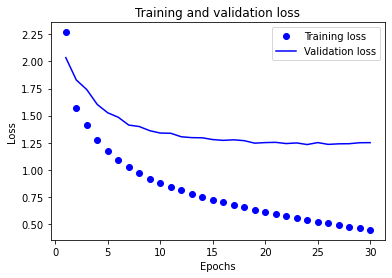

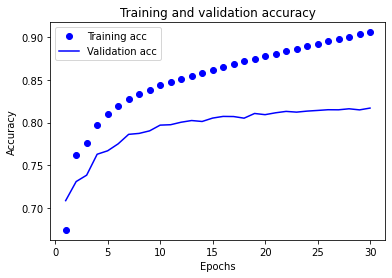

In [187]:
draw_graph(hist.history)

## 6. 모델 평가하기

In [188]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_45 (InputLayer)        [(None, None)]            0         
_________________________________________________________________
embedding_30 (Embedding)     (None, None, 128)         615936    
_________________________________________________________________
masking_15 (Masking)         (None, None, 128)         0         
_________________________________________________________________
lstm_30 (LSTM)               [(None, 256), (None, 256) 394240    
Total params: 1,010,176
Trainable params: 1,010,176
Non-trainable params: 0
_________________________________________________________________


In [189]:
decoder_state_input_h = Input(shape=(256,))
decoder_state_input_c = Input(shape=(256,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb = dec_emb_layer(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb, initial_state = decoder_states_inputs)
decoder_states = [state_h, state_c]

In [190]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_23"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_46 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_31 (Embedding)        (None, None, 128)    1277952     input_46[0][0]                   
__________________________________________________________________________________________________
input_47 (InputLayer)           [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, 256)]        0                                            
___________________________________________________________________________________________

In [191]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [192]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1)) 
    target_seq[0, 0] = fra2idx['<sos>']
    
    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장     
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [193]:
import numpy as np
for seq_index in [200, 300, 400, 500, 600]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: ['bury', 'it', '.']
정답 문장: ['enterre-le', '.']
번역기가 번역한 문장:  la chance . <eos
-----------------------------------
입력 문장: ['hang', 'on', '.']
정답 문장: ['tiens', 'bon', '!']
번역기가 번역한 문장:  attendez . <eos
-----------------------------------
입력 문장: ['shut', 'up', '!']
정답 문장: ['ferme-la', '!']
번역기가 번역한 문장:  la chance ! <eos
-----------------------------------
입력 문장: ['get', 'away', '!']
정답 문장: ['criss', 'ton', 'camp', "d'icit", '!']
번역기가 번역한 문장:  dégage ! <eos
-----------------------------------
입력 문장: ['hurry', 'up', '.']
정답 문장: ['grouille', '!']
번역기가 번역한 문장:  dépêche-toi . <eos


구글 번역 한국어 결과는 다음과 같습니다.

| Eng/Fra sentence | Korean Translation Result |
|------------------|---------------------------|
| bury it.         | 묻어.                     |
| enterre-le.      | 그를 묻어.                |
| la chance        | 운                        |
|------------------|---------------------------|
| hang on.         | 기다려!                   |
| tiens bon!       | 기다리다!                 |
| attendez.        | 기다리다.                 |
|------------------|---------------------------|
| shut up!         | 입 다물어!                |
| ferme-la!        | 입 다물어!                |
| la chance        | 운                        |
|------------------|---------------------------|
| get away!        | 떨어져!                   |
| criss ton camp d'icit! | 여기에서 당신의 캠프를 위기! |
| dégage!          | 분명한!                   |
|------------------|---------------------------|
| hurry up!        | 서둘러!                   |
| grouille!        | 붐비다!                   |
| en route!        | 서둘러!                   |
|------------------|---------------------------|

### 회고
4층 여러 그루분들의 도움으로 제출할 수 있었습니다. 감사합니다.